## Visualization with *yt* and Napari Part 2: annotations

In this notebook series, we'll continue our exploration of using [napari](https://napari.org/) to interactively visualize data loaded and sampled with [*yt*](yt-project.org/). The first notebook in this series (available [here](https://nbviewer.jupyter.org/github/chrishavlin/yt_scratch/blob/master/notebooks/yt_napari_part_1.ipynb)) covered loading both in-memory and dask lazy-loaded *yt* arrays extracted from Fixed Resolution Regions into napari. In this notebook, we'll explore ways to use napari's point and shape layers to add annotations including [Particle Positions](#Particle-Positions) and [3D Streamlines](#3D-Streamlines)


## required packages

Running this notebook requires *yt* and napari in addition to stanard packages from the scipy stack (numpy, matplotlib). 


## imports 

So let's start off by setting up the `qt` environment needed by napari:

In [1]:
 # for napari, do it first!
%gui qt

and import all the packages we'll use

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt 
import os

# yt related
import yt
from yt.units import kpc, Mpc

# napari related imports 
import napari
from napari.utils import nbscreenshot

## Test data 

In this notebook, we'll use the `Enzo_64` test dataset (download [here](http://yt-project.org/data/Enzo_64.tar.gz), 2.4 Gb). So let's load and slice it, centered on the location of the max density:

yt : [INFO     ] 2020-09-09 09:17:04,459 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2020-09-09 09:17:04,459 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2020-09-09 09:17:04,460 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-09-09 09:17:04,460 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-09-09 09:17:04,460 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-09-09 09:17:04,461 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2020-09-09 09:17:04,461 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2020-09-09 09:17:04,461 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2020-09-09 09:17:04,461 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-09-09 09:17:04,462 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 752/752 [00:00<00:00, 9154.52it/s]
yt : [INFO     ] 2020-09-09 09:


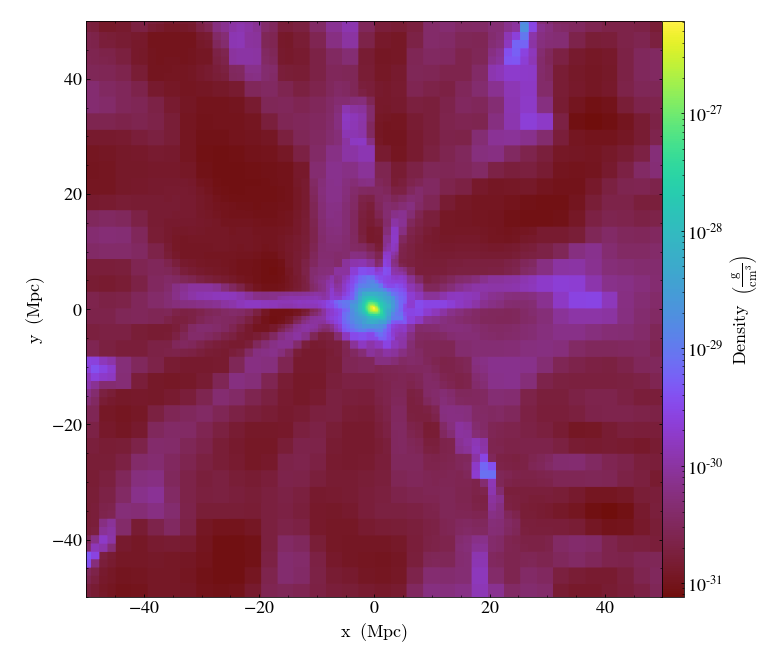

In [3]:
ds = yt.load("Enzo_64/DD0043/data0043")
slc = yt.SlicePlot(ds, 'z', 'density', center='m',width=(100,'Mpc'))
slc.show()

In [4]:
slc.center

[unyt_quantity(0.20263672, 'code_length'),
 unyt_quantity(0.54638672, 'code_length')]

## Particle Positions

In *yt*, we we can add particle positions to the slice following the example in the *yt* docs ([link](https://yt-project.org/doc/visualizing/callbacks.html#overplotting-particle-positions)):


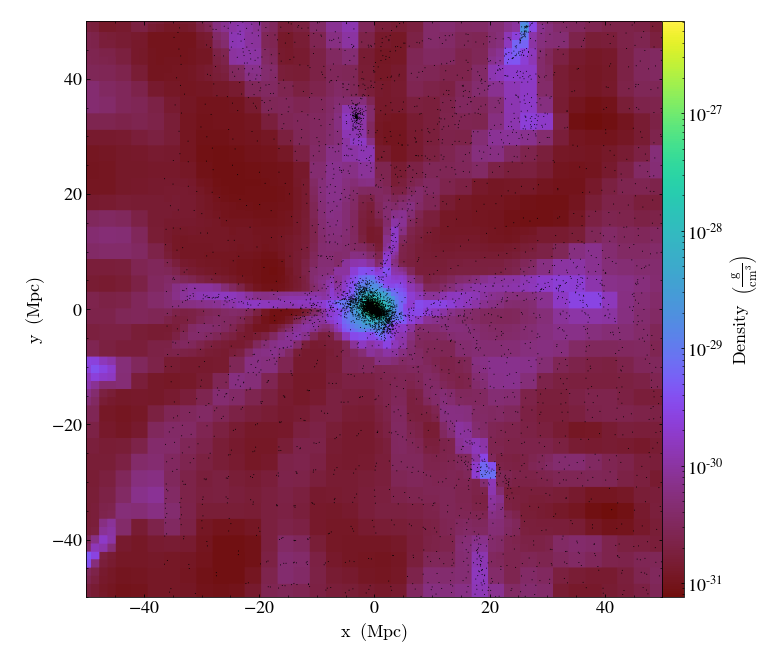

In [5]:
slc.annotate_particles((10, 'Mpc'))
slc.show()

But for napari, we'll need to extract that particle position data. 

Let's start, by following the [previous notebook and pull](LINK) out a Fixed Resolution Region of the log of the density field into memory and adding it to a napari viewer:

In [6]:
cg = ds.r[::300j,::300j,::300j]
dens_log = np.log10(cg['density'])

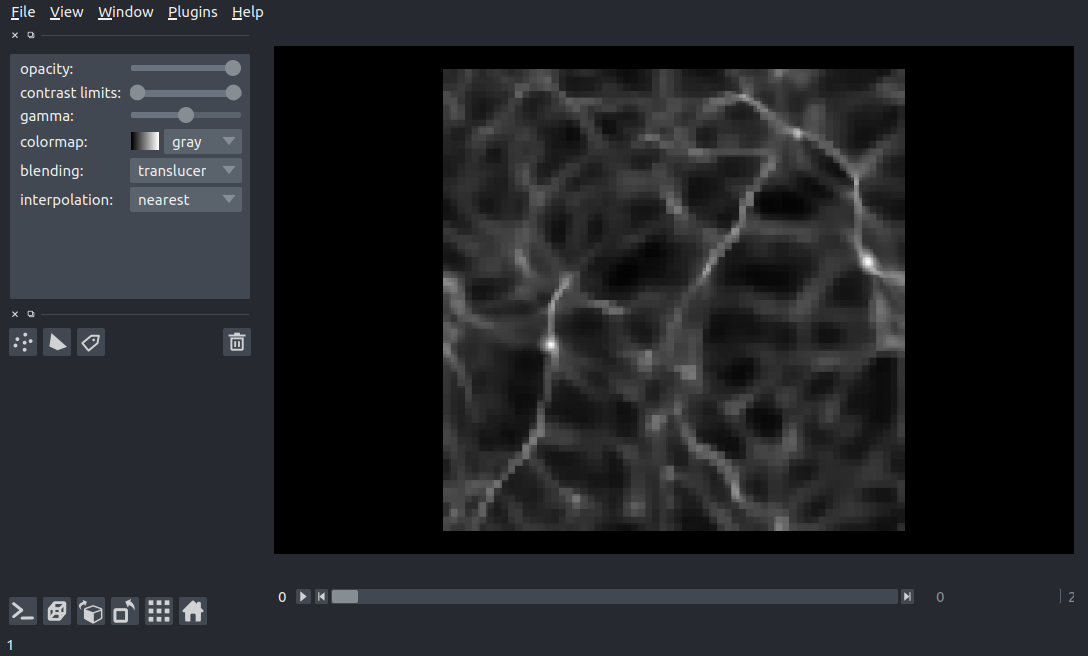

In [7]:
viewer = napari.Viewer()
viewer.add_image(dens_log)
nbscreenshot(viewer)

Now the question is how do we add our particle positions? 

From the napari docs, we have the following example ([link](https://napari.org/tutorials/fundamentals/points.html)) for adding points to an image:

```
from skimage import data
import napari

viewer = napari.view_image(data.astronaut(), rgb=True)
points = np.array([[100, 100], [200, 200], [300, 100]])
viewer.add_points(points, size=30)
```

where `points` is an array with shape `(N, D)` for `N` points in `D` dimensions. 

So all we need to do is extract some particle positions and reshape it to an array of the right dimensions. 

So let's do just that! Easy enough in *yt*: 

In [8]:
ad = ds.all_data()
particles = np.column_stack((ad['particle_position_x'],ad['particle_position_y'],ad['particle_position_z']))
particles.shape

(274305, 3)

Great! We now have our N by D array to add to napari! but wait... these positions are in the `code_length` of the data set:

In [9]:
ad['particle_position_x'][0]

unyt_quantity(0.01247314, 'code_length')

but our image's coordinate system is in pixel values so we need to convert our to a pixel coordinate system. Our domain in `code_length` goes from 0 to 1 in each dimension

In [10]:
print(ds.domain_left_edge)
print(ds.domain_right_edge)

[0. 0. 0.] code_length
[1. 1. 1.] code_length


and we pulled out a 300-pixel image, so we can just multiply the positions by 300: 

In [11]:
particles  = particles * 300 

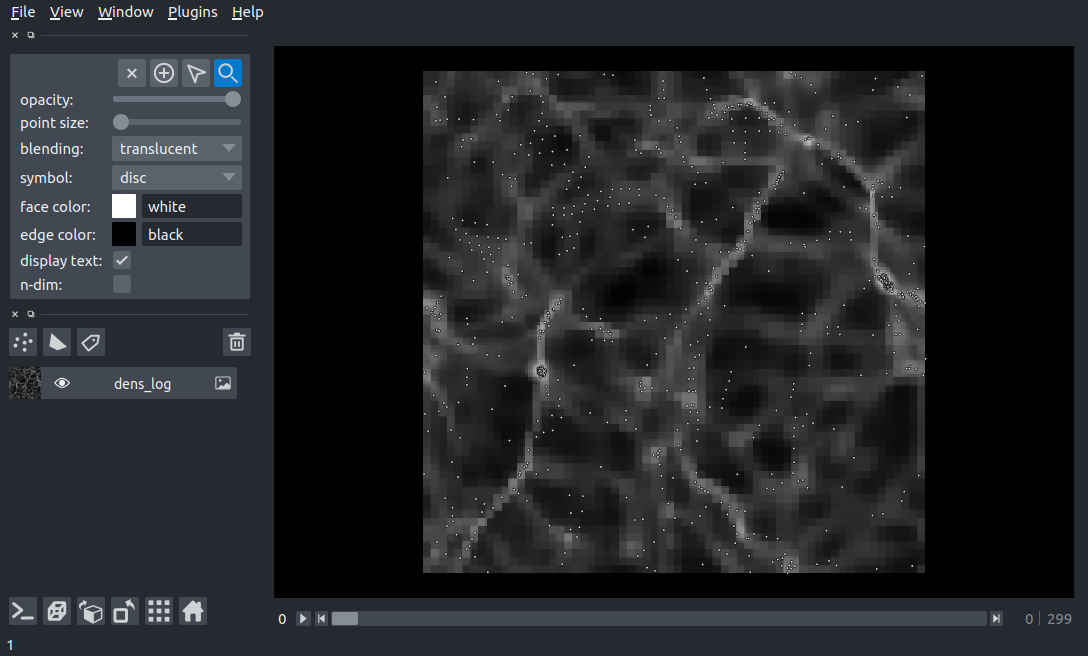

In [12]:
viewer.add_points(particles, size=1)
nbscreenshot(viewer)

Now when we slide through the domain, we also slice through the particle positions: 

<video controls src="resources/napari_5.mp4" />

In [13]:
slc.center

[unyt_quantity(0.20263672, 'code_length'),
 unyt_quantity(0.54638672, 'code_length')]

## 3D Streamlines

Napari also has a `path` shape type that we can use to add 3D streamlines. So let's first calculate some streamlines. Following [*yt*'s example streamline notebook](https://yt-project.org/doc/visualizing/streamlines.html), we first define our streamline starting positions as random position within a range of the domain center:

In [14]:
N = 30
c = ds.domain_center
scale = ds.domain_width[0]*.25
pos_dx = np.random.random((N,3))*scale - scale/2
pos = c+pos_dx

Now we create and integrate our streamline object (this step can take a few minutes):

In [15]:
# Create streamlines of the 3D vector velocity and integrate them through
# the box defined above
streamlines = yt.visualization.api.Streamlines(ds, pos, 'velocity_x', 'velocity_y', 'velocity_z',
                          length=30.0*Mpc, get_magnitude=True)
streamlines.integrate_through_volume()


yt : [INFO     ] 2020-09-09 09:19:38,371 AMRKDTree rebuilt, Final Volume: 1.000000e+00
Streamlining: 100%|██████████| 30/30 [00:00<00:00, 146.70it/s]


The `streamlines` object now has a list of streamlines in `streamlines.streamlines`. To access the first 5 positions of the the first streamline:

In [16]:
streamlines.streamlines[0][:5]

unyt_array([[0.462263  , 0.6093524 , 0.59120923],
            [0.46132888, 0.60927614, 0.59094234],
            [0.46039483, 0.60920003, 0.59067515],
            [0.45946082, 0.60912416, 0.59040776],
            [0.45852679, 0.6090486 , 0.59014033]], 'code_length')

To add to napari, we can use the `viewer.add_shapes` with a `shape_type` of `line`, but first we once again need to convert to pixel coordinates

In [17]:
streamlines.streamlines = streamlines.streamlines * 300 

and then add to the viewer with `add_shapes` (we'll also switch to a 3D view): 

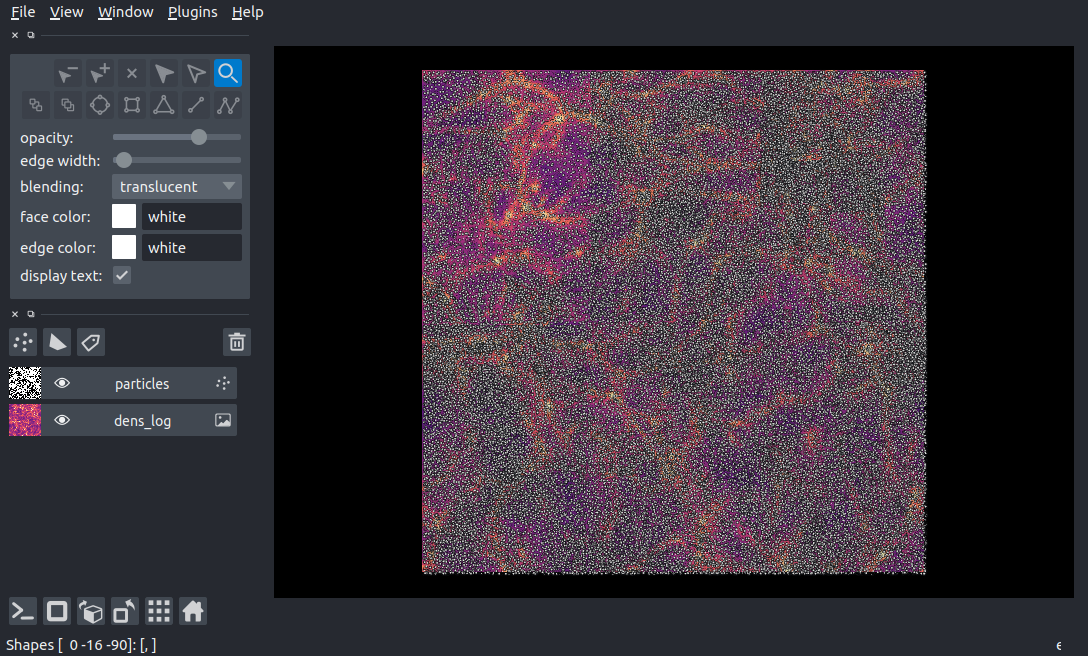

In [18]:
viewer.add_shapes(streamlines.streamlines, shape_type='path', edge_width=1, edge_color=['white'])
viewer.dims.ndisplay = 3
nbscreenshot(viewer)

Let's turn off the particles and check out those streamlines:


<video controls src="resources/napari_6.mp4" />